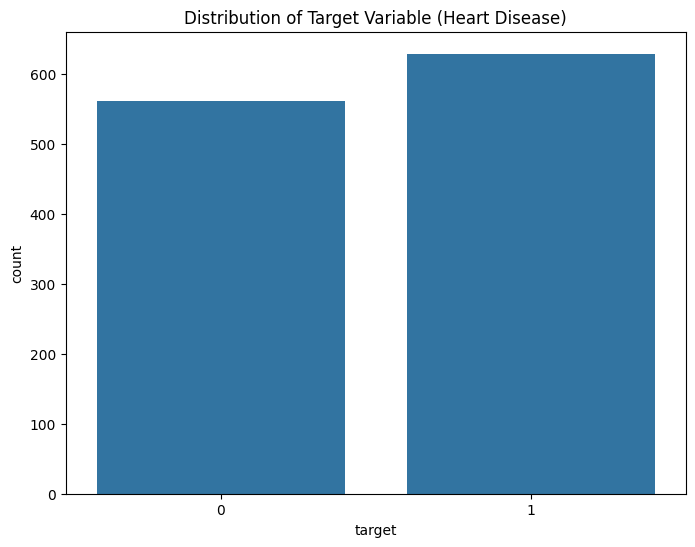

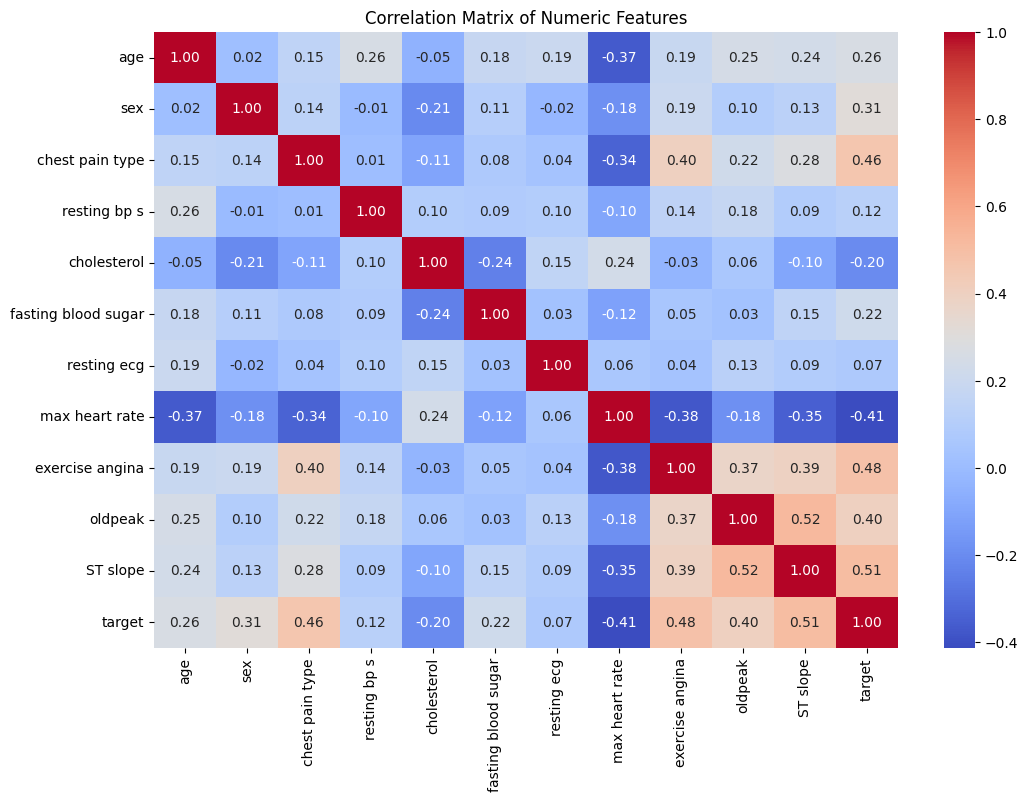

Selected Features by Dragonfly Algorithm: Index(['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol',
       'fasting blood sugar', 'max heart rate', 'oldpeak', 'ST slope'],
      dtype='object')
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'classifier__xgb__n_estimators': 50, 'classifier__xgb__learning_rate': 0.01, 'classifier__rf__n_estimators': 50, 'classifier__rf__max_depth': None, 'classifier__lr__C': 10, 'classifier__lgb__n_estimators': 100, 'classifier__lgb__learning_rate': 0.01, 'classifier__gb__n_estimators': 100, 'classifier__gb__max_depth': 5, 'classifier__gb__learning_rate': 0.1, 'classifier__et__n_estimators': 100, 'classifier__et__max_depth': 20, 'classifier__cat__iterations': 100, 'classifier__cat__depth': 5, 'classifier__bagging__n_estimators': 50, 'classifier__ada__n_estimators': 50}
Best cross-validation accuracy:  0.9155066252893947
Test Accuracy: 0.9246031746031746
              precision    recall  f1-score   su

In [6]:
import warnings
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier,
    AdaBoostClassifier, BaggingClassifier
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score
)
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
import pickle

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load the dataset
df = pd.read_csv('heart_statlog_cleveland_hungary_final.csv')

# Data visualization: distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='target')
plt.title('Distribution of Target Variable (Heart Disease)')
plt.show()

# List of numeric features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Correlation matrix for numeric features
plt.figure(figsize=(12, 8))
corr_matrix = df[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Features and target
X = df.drop('target', axis=1)
y = df['target']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dragonfly Optimization for feature selection
class DragonflyOptimizationFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_iter=10, population_size=50):
        self.n_iter = n_iter
        self.population_size = population_size
    
    def fit(self, X, y):
        self.X = X.values
        self.y = y
        self.feature_names = X.columns

        def objective_function(solution):
            mask = np.array(solution, dtype=bool)
            if not any(mask):
                return 1.0
            X_selected = self.X[:, mask]
            estimator = RandomForestClassifier(n_estimators=10, random_state=42)
            score = np.mean(cross_val_score(estimator, X_selected, self.y, cv=5, scoring='accuracy'))
            return 1 - score

        population = np.random.randint(0, 2, (self.population_size, self.X.shape[1]))
        fitness = np.array([objective_function(ind) for ind in population])
        best_idx = np.argmin(fitness)
        best_solution = population[best_idx].copy()

        for iteration in range(self.n_iter):
            for i in range(self.population_size):
                # Sigmoid transformation
                population[i] = np.random.rand(self.X.shape[1]) < (1 / (1 + np.exp(-population[i])))
            fitness = np.array([objective_function(ind) for ind in population])
            best_idx = np.argmin(fitness)
            best_solution = population[best_idx].copy()

        self.selected_features_ = self.feature_names[np.array(best_solution, dtype=bool)]
        return self

    def transform(self, X):
        return X[self.selected_features_]

# Initialize the Dragonfly Algorithm for feature selection
da = DragonflyOptimizationFeatureSelector(n_iter=10, population_size=50)
da.fit(X, y_encoded)
selected_features = da.selected_features_

# Print the selected features
print("Selected Features by Dragonfly Algorithm:", selected_features)

# Use only the selected features
X_selected = X[selected_features]

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y_encoded)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Preprocess the data using ColumnTransformer and Pipeline
# Ensure to use selected features after feature selection
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_selected.columns)  # Use columns from X_selected
    ]
)

# Define the ensemble model within a pipeline with additional classifiers
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(random_state=42, max_iter=1000)),
            ('rf', RandomForestClassifier(random_state=42)),
            ('gb', GradientBoostingClassifier(random_state=42)),
            ('et', ExtraTreesClassifier(random_state=42)),
            ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
            ('cat', CatBoostClassifier(random_state=42, verbose=0)),
            ('lgb', LGBMClassifier(random_state=42, verbosity=-1)),
            ('ada', AdaBoostClassifier(random_state=42)),
            ('bagging', BaggingClassifier(random_state=42))
        ],
        voting='soft', n_jobs=-1
    ))
])

# Hyperparameter grid
param_grid = {
    'classifier__lr__C': [0.01, 0.1, 1, 10],
    'classifier__rf__n_estimators': [50, 100, 200],
    'classifier__rf__max_depth': [None, 10, 20],
    'classifier__gb__n_estimators': [50, 100],
    'classifier__gb__learning_rate': [0.01, 0.1],
    'classifier__gb__max_depth': [3, 5],
    'classifier__et__n_estimators': [50, 100],
    'classifier__et__max_depth': [None, 10, 20],
    'classifier__xgb__n_estimators': [50, 100],
    'classifier__xgb__learning_rate': [0.01, 0.1],
    'classifier__cat__depth': [3, 5],
    'classifier__cat__iterations': [50, 100],
    'classifier__lgb__n_estimators': [50, 100],
    'classifier__lgb__learning_rate': [0.01, 0.1],
    'classifier__ada__n_estimators': [50, 100],
    'classifier__bagging__n_estimators': [50, 100]
}

# Setup the randomized search with cross-validation
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: ", random_search.best_score_)

# Evaluate on the test set
y_pred = random_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")
print(classification_report(y_test, y_pred))

# Save the final model as a pickle file
with open('heart_disease_predictor2.pkl', 'wb') as f:
    pickle.dump(random_search.best_estimator_, f)

print("Model saved as 'heart_disease_predictor.pkl'")
